In [1]:
#Say no to warnings!
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

!pip install iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import re
import string
import nltk
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, Input, GRU, BatchNormalization
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# 1. Preliminary data analysis

In [3]:
BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

In [4]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [5]:
len(df)

159571

The dataset consists of 159571 comments. Each comment can have one or more labels depending on the content. The categories of negativity present are:

- Toxic
- Severe toxic
- Obscene
- Threat
- Insult
- Identity hate

Column sum_injurious shows the total number of labels assigned to the comment (0 represents a non-offensive/threatening/obscene comment).

In [6]:
df.isna().sum()

,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0
sum_injurious,0


The dataset has no null values. Let's see how many comments are present for each negative category.

In [7]:
#create copy of df
df2=df.copy()

#drop sum_injurious
df2=df2.drop('sum_injurious', axis=1)

#add not negative category
df2['not_negative']=df2.iloc[:,-6:].sum(axis=1)
#assign 0 if not_negative >0 else 1. 0=negative, 1=not negative
df2['not_negative']=df2['not_negative'].apply(lambda x: 0 if x>0 else 1)

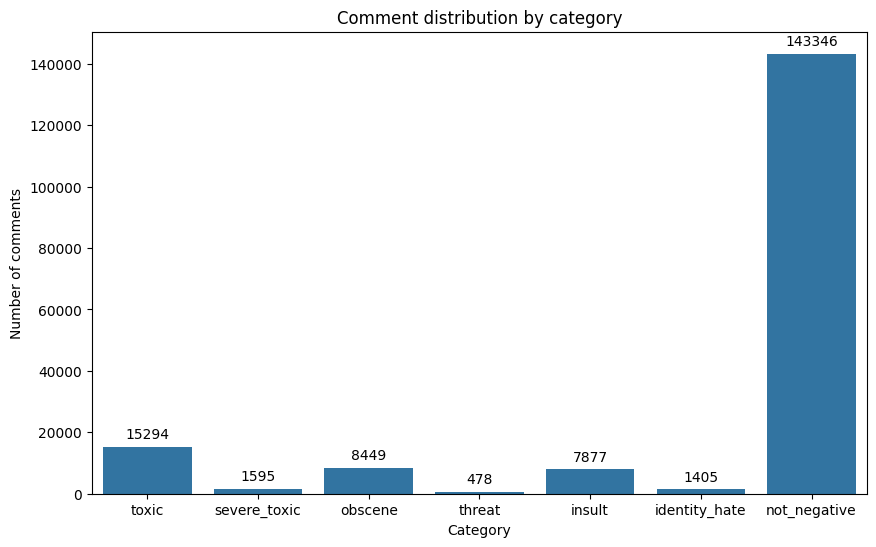

In [8]:
#column name
label=df2.columns[-7:]

#sum by label
comment_by_label=df2[label].sum()


# figure size
plt.figure(figsize=(10, 6))

# bar chart
ax = sns.barplot(x=label, y=comment_by_label)

# title, x and y label
ax.set_title('Comment distribution by category')
ax.set_xlabel('Category')
ax.set_ylabel('Number of comments')

# Add value to bars
for p in ax.patches:
  ax.annotate(format(int(p.get_height()), 'd'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

# show graph
plt.show()

The dataset is strongly unbalanced in favor of non-negative comments.

Focusing only on negative categories, the dataset is also unbalanced here. Considering the two extremes (toxic and threat) we have that the comments belonging to the threat category are about 32 times less than those belonging to the toxic category.


# 2. Preprocessing

In order to make the data compatible with the model, it is necessary to carry out a pre-processing of the data. Preprocessing involves the following steps:

- Stopwords removal
- Split the dataset into train, test, and validation set
- Tokenization and padding
- Balancing the training set using MLSMOTE

**2.1 Stopwords**

Let's remove the stopwords from the dataset. Stopwords do not bring any added value for the sentyment analysis task.

In [9]:
#download stopwords
nltk.download('stopwords')

#set english language
stop_words = stopwords.words('english')


def clean_text(text):
    """
    Remove stopwords from a corpus

    args:
        text (str): corpus

    returns:
        text (str): corpus without stopwords
    """
    #convert in lower case
    text = text.lower()
    #remove punctuation
    text = re.sub(f"[{string.punctuation}]","", text)
    #remove number
    text = re.sub("\\d+", "", text)
    #remove stopwords
    text= " ".join([word for word in text.split() if word not in stop_words])
    return text

df['comment_text']=df['comment_text'].apply(clean_text)
df['comment_text'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,comment_text
0,explanation edits made username hardcore metal...
1,daww matches background colour im seemingly st...
2,hey man im really trying edit war guy constant...
3,cant make real suggestions improvement wondere...
4,sir hero chance remember page thats


**2.2 Train, test and validation dataset**

In [10]:
#Comment dataset
X=df['comment_text']
#label dataset
y=df.drop(['comment_text', 'sum_injurious'], axis=1)

#Multilabel stratified split
mss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

#Train set
for train_index, test_index in mss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#Test and validation set
for test_index, val_index in mss.split(X_test, y_test):
    X_test, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
    y_test, y_val = y_test.iloc[test_index], y_test.iloc[val_index]

**2.3 Tokenization and Padding**

In [11]:
tokenizer=Tokenizer()

#Tokenizer fit on train set
tokenizer.fit_on_texts(X_train)

# Word frequencies
word_counts = tokenizer.word_counts
word_frequencies = list(word_counts.values())
word_frequencies.sort(reverse=True)

# cumulative frequencies
cumulative_frequencies = np.cumsum(word_frequencies) / np.sum(word_frequencies)

#Find min words value to cover 95% of Xtrain
num_words_95 = np.searchsorted(cumulative_frequencies, 0.95)
print(f"Number of words to cover 95% of vocabulary: {num_words_95}")

Number of words to cover 95% of vocabulary: 39719


Let's set he number of words of the tokenizer object at 40000.

In [12]:
#Instance Tokenizer with num_words=40000
tokenizer = Tokenizer(num_words = 40000, oov_token="<OOV>")

#Tokenizer fit on train set
tokenizer.fit_on_texts(X_train)

#Convert X_train, X_test and X_val into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
val_sequences = tokenizer.texts_to_sequences(X_val)

#Evaluate vocabulary size
vocabulary_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 183471


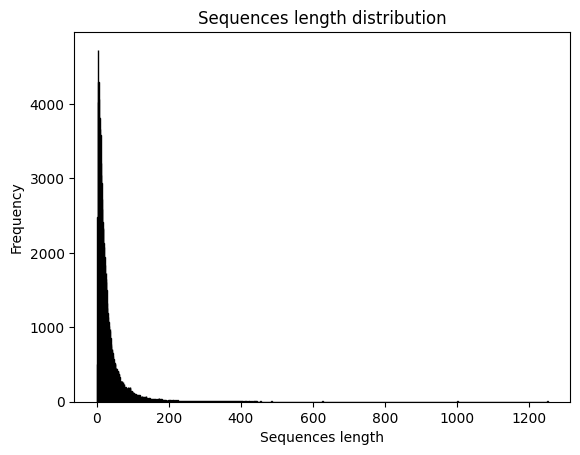

In [13]:
# Sequences length
length = [len(seq) for seq in train_sequences]

# Sequences length distribution
plt.hist(length, bins=range(1, max(length) + 2), edgecolor='black')
plt.title('Sequences length distribution')
plt.xlabel('Sequences length')
plt.ylabel('Frequency')
plt.show()

From the graph, it can be seen that the vast majority of comments are less than 200 tokens in length.

Let's evaluate the maximum length and minimum length needed to cover 95% of the length of the training set comments.

In [14]:
#95° percentile
length_95 = np.percentile(length, 95)

print(f'Max comment length: {max(length)}')
print(f'Length to cover 95% of train set: {length_95}')

Max comment length: 1250
Length to cover 95% of train set: 116.0


With a length of about 10% of the maximum length, it is possible to cover 95% of the length of the comments of the train set. Let's set the padding value at 120 tokens so as not to weigh down the model.

In [15]:
maxlen = 120

#Train, test and val sequences padding
padded_train_sequences = pad_sequences(train_sequences, maxlen=maxlen)
padded_test_sequences = pad_sequences(test_sequences, maxlen=maxlen)
padded_val_sequences = pad_sequences(val_sequences, maxlen=maxlen)

**2.4 Dataset balancing**

To balance the dataset it is possible to implement a variant of SMOTE that supports a multilabel problem.

In [16]:
def MLSMOTE(X, y, n_samples=1000, k_neighbors=5, random_state=42):
    """Apply MLSMOTE to generate new synthetic sample campioni.

    args:
        X = features after tokenization and padding
        y= label
        n_samples: Number of synthetic samples to generate (default is 1000)
        k_neighbors: Number of nearest neighbors to consider (default is 5).
        random_state: Seed for random number generation (default is 42).

    returns the original and synthetic samples combined
    """

    np.random.seed(random_state)

    # Find minority classes
    label_counts = y.sum(axis=0)
    min_classes = label_counts[label_counts < label_counts.median()].index

    # Apply SMOTE only to the example with at least one minority classes
    minority_indices = y[min_classes].sum(axis=1) > 0
    X_minority, y_minority = X[minority_indices], y[minority_indices]

    # Find nearest neighbors
    neigh = NearestNeighbors(n_neighbors=k_neighbors)
    neigh.fit(X_minority)

    synthetic_X, synthetic_y = [], []
    for _ in range(n_samples):
        index = np.random.randint(0, len(X_minority))
        x_sample = X_minority.iloc[index]
        y_sample = y_minority.iloc[index]

        # Find nearest neighbors
        neighbors = neigh.kneighbors([x_sample], return_distance=False)[0]
        neighbor = X_minority.iloc[np.random.choice(neighbors)]

        # Generate new sample
        new_sample = x_sample + np.random.rand() * (neighbor - x_sample)

        # Generate new label combining the original label
        new_label = y_sample | y_minority.iloc[np.random.choice(neighbors)]

        synthetic_X.append(new_sample)
        synthetic_y.append(new_label)

    return np.vstack([X, np.array(synthetic_X)]), np.vstack([y, np.array(synthetic_y)])

In [17]:
#reset train index
X_train_df = pd.DataFrame(padded_train_sequences)
X_train_df.reset_index(drop=True, inplace=True)
y_train_reset = y_train.reset_index(drop=True)

#Apply MLSMOTE to train set
X_train_balanced, y_train_balanced = MLSMOTE(X_train_df, y_train_reset, n_samples=5000)

In [18]:
#copy y_train_reset
y_train_reset2=y_train_reset.copy()

#add not negative column
y_train_reset2['not_negative']=y_train_reset2.iloc[:,-6:].sum(axis=1)
y_train_reset2['not_negative']=y_train_reset2['not_negative'].apply(lambda x: 0 if x>0 else 1)

#copy y_train_balanced
y_train_balanced2=pd.DataFrame(y_train_balanced.copy(), columns=y_train_reset.columns)

#add not negative column
y_train_balanced2['not_negative']=y_train_balanced2.iloc[:,-6:].sum(axis=1)
y_train_balanced2['not_negative']=y_train_balanced2['not_negative'].apply(lambda x: 0 if x>0 else 1)

#evaluate sum by label and concat the two dataframe (original and after balancing)
df_train_compare=pd.concat([y_train_reset2.sum(axis=0), y_train_balanced2.sum(axis=0)], axis=1)
df_train_compare.columns=['Original Train Set', 'After MLSMOTE Train Set']


print(df_train_compare)

               Original Train Set  After MLSMOTE Train Set
toxic                       10706                    15656
severe_toxic                 1116                     4770
obscene                      5914                    10497
threat                        335                     1675
insult                       5514                    10082
identity_hate                 983                     4252
not_negative               100357                   100357


Focusing on negative labels, the dataset continues to be unbalanced, however the gap between the various labels has narrowed. The minority classes have increased more than those with a smaller number of examples.

Considering the two extremes between the negative classes (toxic and threat) we have that before balancing the threat class had a number equal to about 3% of toxic. After balancing, the threat class has a number equal to about 11% of the toxic class.

Furthermore, since the number of negative comments in all the categories present has increased and the number of non-negative comments has remained fixed, the gap between the two macro classes of comments (negative and non-negative) has been reduced.

# 3. Model

In [24]:
clear_session()

model_GRU=Sequential()
model_GRU.add(Input(shape=(maxlen,)))
model_GRU.add(Embedding(input_dim=vocabulary_size, output_dim=128))
model_GRU.add(Dropout(0.2))
model_GRU.add(BatchNormalization())
model_GRU.add(Bidirectional(GRU(units=256, activation='tanh', return_sequences=True)))
model_GRU.add(Bidirectional(GRU(units=128, activation='tanh')))
model_GRU.add(Dropout(0.2))
model_GRU.add(BatchNormalization())
model_GRU.add(Dense(units=128, activation='relu'))
model_GRU.add(Dense(units=6, activation='sigmoid'))

model_GRU.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model_GRU.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 120, 128)       │    23,484,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 120, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 120, 512)       │       592,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       493,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,605,446 (93.86 MB)

 Trainable params: 24,604,678 (93.86 MB)

 Non-trainable params: 768 (3.00 KB)

In [20]:
#convert y_test into np array
y_test=y_test.values

#convert y_val into np array
y_val=y_val.values

In [21]:
#check train, test and validation set type
print(f'X_train type: {type(X_train_balanced)}')
print(f'y_train type: {type(y_train_balanced)}')
print(f'X_test type: {type(padded_test_sequences)}')
print(f'y_test type: {type(y_test)}')
print(f'X_val type: {type(padded_val_sequences)}')
print(f'y_val type: {type(y_val)}')

X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
X_test type: <class 'numpy.ndarray'>
y_test type: <class 'numpy.ndarray'>
X_val type: <class 'numpy.ndarray'>
y_val type: <class 'numpy.ndarray'>


In [22]:
#Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True)

#Reduce Learning rate callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1)

In [25]:
#Model fit
hist=model_GRU.fit(X_train_balanced, y_train_balanced,
                   epochs=20, validation_data=(padded_val_sequences, y_val), batch_size=64,
                   callbacks=[early_stopping, reduce_lr])

Epoch 1/20
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 89s 47ms/step - accuracy: 0.7268 - loss: 0.1785 - val_accuracy: 0.9733 - val_loss: 0.0690 - learning_rate: 0.0010
Epoch 2/20
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 141s 46ms/step - accuracy: 0.9076 - loss: 0.1163 - val_accuracy: 0.8259 - val_loss: 0.0780 - learning_rate: 0.0010
Epoch 3/20
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 86s 47ms/step - accuracy: 0.9135 - loss: 0.1021 - val_accuracy: 0.9327 - val_loss: 0.0682 - learning_rate: 0.0010
Epoch 4/20
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 140s 46ms/step - accuracy: 0.9574 - loss: 0.0927 - val_accuracy: 0.9888 - val_loss: 0.0573 - learning_rate: 0.0010
Epoch 5/20
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 84s 46ms/step - accuracy: 0.9579 - loss: 0.0837 - val_accuracy: 0.9586 - val_loss: 0.0601 - learning_rate: 0.0010
Epoch 6/20
1823/1824 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9640 - loss: 0.0769
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 84s 46ms/step - accur

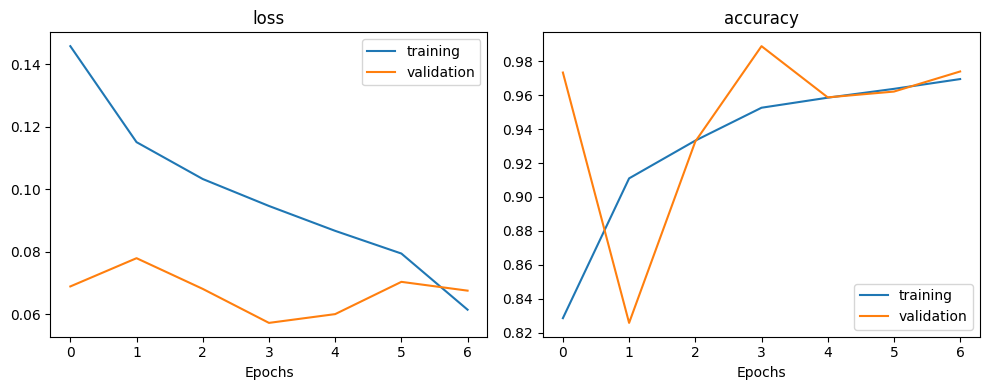

In [27]:
def plot_learning_curves(hist):
  """
  Plot learning curves for a given model.

  args:
      hist = model history
  """
  plt.figure(figsize=(10,4))
  for subplot,curve in enumerate(["loss", "accuracy"]):
    plt.subplot(1,2,subplot + 1)
    plt.plot(hist.history[curve], label = "training")
    plt.plot(hist.history["val_" + curve], label = "validation")
    plt.xlabel('Epochs')
    plt.legend()
    plt.title(curve)
  plt.tight_layout();

plot_learning_curves(hist)

The training shows a significant improvement in the early epochs on both accuracy and loss for both training and validation data.

On the training set, both accuracy and loss have continued to improve as the ages have progressed. In the validation set both loss and accuracy show a dancing behavior.

Early stopping by monitoring the loss on the validation set, it stopped training at epoch 7, recovering the weights obtained at epoch 4 (where the lowest validation loss was recorded). In this era, the model has high performance on both training and validation. The accuracy on the validation set is a higher than the accuracy on training set, that means there is no overfitting.

In [28]:
# Save wheights
with open('model_weights.pkl', 'wb') as file:
    pickle.dump(model_GRU.get_weights(), file)

# Save history
with open('training_history.pkl', 'wb') as file:
    pickle.dump(hist.history, file)


In [ ]:
# Load wheights
with open('model_weights.pkl', 'rb') as file:
model_weights = pickle.load(file)

#Set model wheights
model_GRU.set_weights(model_weights)

#Load history
with open('train_history.pkl', 'rb') as file:
  hist = pickle.load(file)

# 4. Model evaluation

In [29]:
def predict_binary(model, padded_test):
  """
  Predict binary labels for a given model and test data.

  args:
      model = trained model
      padded_test = test data after padding

  returns the predicted binary labels
  """

  y_pred=model.predict(padded_test)

  y_pred_binary = (y_pred >= 0.5).astype(int)

  return y_pred_binary

In [30]:
#Test set prediction
y_pred_test=predict_binary(model_GRU, padded_test_sequences)

1048/1048 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step


In [31]:
#classification report
print(classification_report(y_test, y_pred_test, target_names=y_train_reset.columns))

               precision    recall  f1-score   support

        toxic       0.75      0.77      0.76      3212
 severe_toxic       0.42      0.43      0.42       335
      obscene       0.76      0.83      0.79      1774
       threat       0.38      0.10      0.16       100
       insult       0.65      0.71      0.68      1654
identity_hate       0.49      0.37      0.42       295

    micro avg       0.71      0.73      0.72      7370
    macro avg       0.58      0.54      0.54      7370
 weighted avg       0.70      0.73      0.71      7370
  samples avg       0.06      0.07      0.06      7370



Due to the unbalanced nature of the dataset, the model has variable metrics depending on the class.

The model show good metrics for the most present classes (toxic, obscene and insult).

The model suffers in correctly identifying the smaller classes (severe toxic, threat and identity hate), with an increased presence of false positives and false negatives compared to the majority classes.

The class that achieve the worst performance is threat, that is also the with an increased presence of false positives and false negatives. It is important to underline the recall value of 0.10 , almost all of the example are false negative.

In summary, the model behaves well on the toxic, obscene and insult categories, i.e. those present in greater numbers within the dataset. It struggles extremely for the threat category that presents the fewest examples.

In [32]:
def plot_confusion_matrix_and_report_side_by_side(y_true, y_pred, labels_name):
    """
    Show confusion matrix and classification report for each label  side by side

    args:
        y_true (np.ndarray): np array of true label.
        y_pred (np.ndarray): np array of predicted label
        labels_name (list): list of label name.
    """
    #number of labels
    num_rows = y_true.shape[1]

    #number of column for plot
    num_cols = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))
    axes = axes.flatten()

    for i in range(num_rows):
        # Evaluate confusion matrix
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[2 * i], cmap=plt.cm.Blues, colorbar=False, values_format='d')
        axes[2 * i].set_title(f'Confusion Matrix for {labels_name[i]}')
        axes[2 * i].grid(False)

        # evaluate classification report
        report = classification_report(y_true[:, i], y_pred[:, i], zero_division=0)
        axes[2 * i + 1].text(0, 0, report, fontsize=10, family='monospace')
        axes[2 * i + 1].axis('off')
        axes[2 * i + 1].set_title(f'Classification Report for {labels_name[i]}')

    plt.tight_layout()
    plt.show()

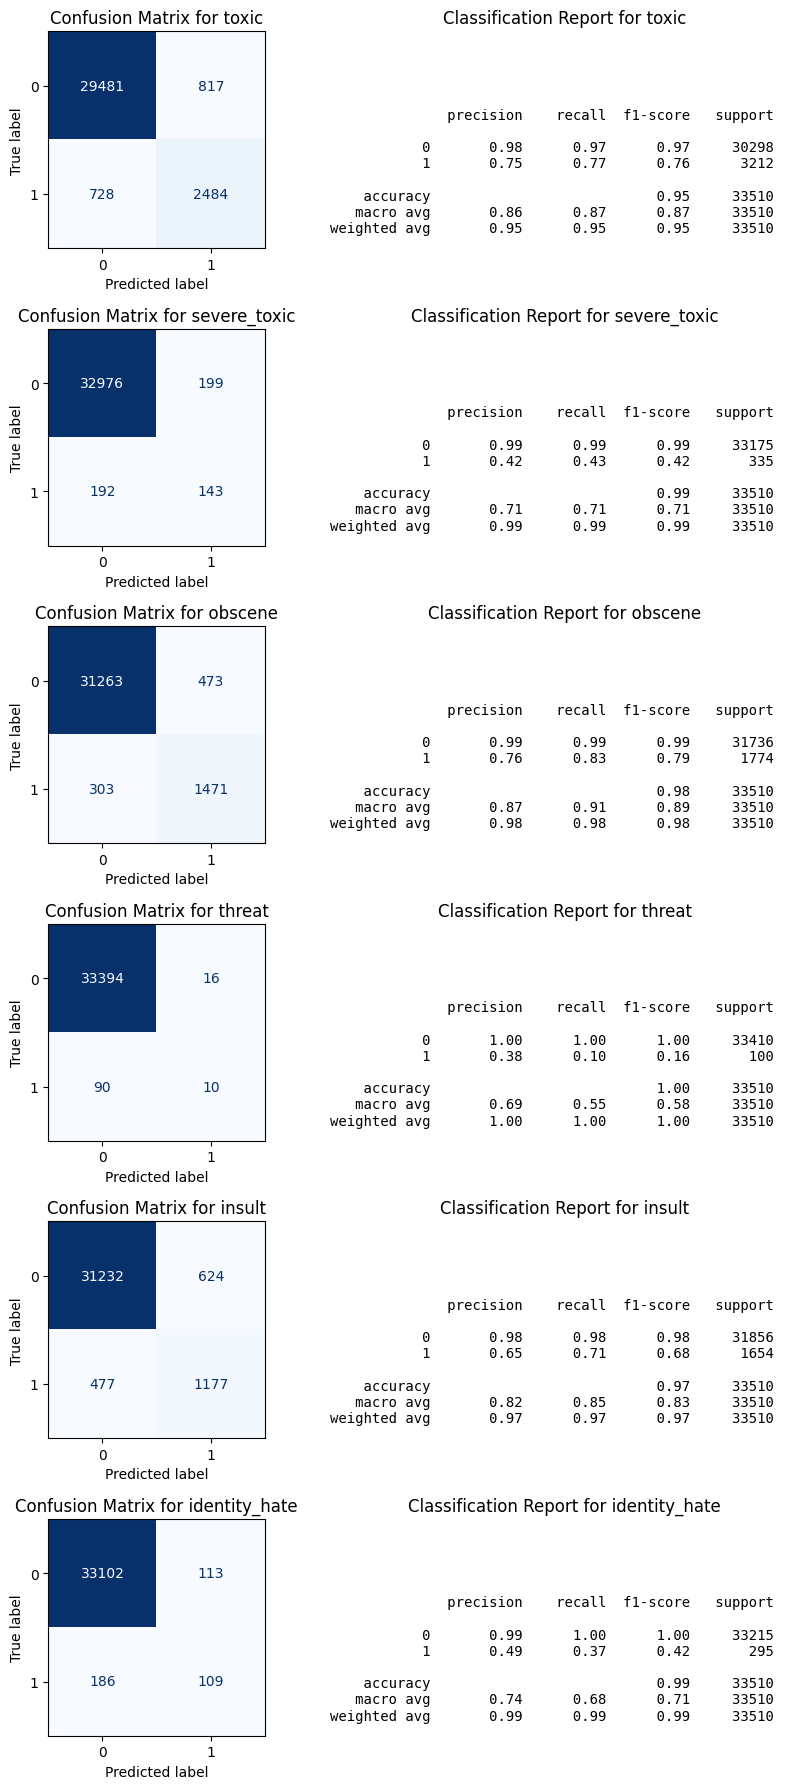

In [33]:
plot_confusion_matrix_and_report_side_by_side(y_test, y_pred_test, y_train_reset.columns)

The results shown by the classification reports for class 1 are the same as those shown in the overall classification report. Class-by-class classification reports explicitly show how the model behaves even with respect to non-negative comments.

Since the dataset is skewed in favor of positive comments, all classes (with the exception of threat) have an average f1-score of more than 70%.

As seen above, the model struggles especially with the threat class. From the detail of the confusion matrix for this class, it can be observed that out of 100 examples, the model correctly classified only 10 of them. The remaining 90 were classified as belonging to class 0, in addition the false positive are greater that the true positive.

# 5. Conclusion

The model obtained is able to generalize on most of the classes present. The unbalanced nature of the dataset leads to lower performance on the less present classes (severe toxic, threat, identity hate) and in particular in the case of threats it fails to achieve sufficient performance.

As a next step, the dataset should be integrated with further examples for minority classes.

So far the attention has been focused on the individual classes, however the task is that of multilabel classification, however the aim is to filter out negative comments. So let's see how the model behaves considering only two labels: Not negative and negative.

In [36]:
#y_test_bin. 0=non negative , 1=negative comment
y_test_bin = np.where(y_test.sum(axis=1) == 0, 0, 1)

#y_pred_test_bin
y_pred_test_bin = np.where(y_pred_test.sum(axis=1) == 0, 0, 1)

In [37]:
print(classification_report(y_test_bin, y_pred_test_bin, target_names=['Non negative', 'Negative']))

              precision    recall  f1-score   support

Non negative       0.97      0.98      0.97     30089
    Negative       0.78      0.76      0.77      3421

    accuracy                           0.95     33510
   macro avg       0.88      0.87      0.87     33510
weighted avg       0.95      0.95      0.95     33510



In general, the model performs very well, managing to filter out more than 75% of negative comments.